In [89]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math
import random
import warnings
import sys

warnings.filterwarnings('ignore')

In [90]:
def plotTwoLabelData(dataFrame_Name, dfLength):
    
    plt.xlabel('x data')
    plt.ylabel('y data')
    for i in range(0, dfLength):
        if dataFrame_Name['2'][i] == 1.0:
            plt.scatter(dataFrame_Name['0'][i], dataFrame_Name['1'][i], c = 'r', marker = '.')
        elif dataFrame_Name['2'][i] == 2.0:
            plt.scatter(dataFrame_Name['0'][i], dataFrame_Name['1'][i], c = 'b', marker = '.')
            
    labelOne = mpatches.Patch(color='red', label='1')
    labelTwo = mpatches.Patch(color='blue', label='2')
    plt.legend(handles = [labelOne, labelTwo])

In [91]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
def findPredictClass(predictProbability):
    if predictProbability [0] >= predictProbability [1]:
        train_predictClass = 0
    else:
        train_predictClass = 1
    return train_predictClass

In [92]:
def DataBackpropagation(CSV_Name, stop_loss, stop_iteration, stop_trainIdenRate, stop_testIdenRate, lr, lrRate, hiddenNeuronsNum):
    
    data_CSV = CSV_Name + '.CSV'
    data_df = pd.DataFrame(pd.read_csv(data_CSV, low_memory = False))
    
    # shuffle and split the data
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    dataLength = len(data_df)
    trainData_df = data_df.loc['0':str(2*dataLength/3-1),'0':'2']             # train data
    testData_df  = data_df.loc[str(2*dataLength/3-1):dataLength,'0':'2']      # test data
    testData_df.reset_index(inplace=True)                                     # reset index 0~dataLength
    print("data length :",len(data_df))
    print("train data length :",len(trainData_df))
    print("test data length :",len(testData_df))
    
    # plot the Data chart
    plt.title('All Data')
    plotTwoLabelData(data_df, len(data_df))
    plt.show()
    plt.title('Training data')
    plotTwoLabelData(trainData_df, len(trainData_df))
    plt.show()
    plt.title('Test data')
    plotTwoLabelData(testData_df, len(testData_df))
    plt.show()
    
    # make dataframe to dict
    train_dict = trainData_df.to_dict(orient='dict')
    test_dict  = testData_df.to_dict(orient='dict')
    
    # 參數設定
    loss_train  = 0
    loss_flag = True
    loss_train_history = []
    loss_test_history = []
    iteration = 0
    NUM = hiddenNeuronsNum
            
    layer1 = np.random.rand(3,hiddenNeuronsNum)
    layer2 = np.random.rand(hiddenNeuronsNum+1,2)
    #print("Hidden Layer Number is ",hiddenNeuronsNum)
    #print("\nOriginal weight/bias of layer1 \n",layer1)
    #print("\nOriginal weight/bias of layer2 \n",layer2)
    
    # Training and compute
    while (loss_flag):
    
        train_predict = 0
        loss_train = 0
        loss_train_ = 0
        loss_test = 0
        loss_test_ = 0
        layer1_changeValue = np.zeros((3,hiddenNeuronsNum))
        layer2_changeValue = np.zeros((hiddenNeuronsNum+1,2))
        iteration = iteration + 1
        
        for i in range (len(trainData_df)):
            train_inputArr = np.array([train_dict['0'][i], train_dict['1'][i], 1])
            train_tempLabel = int(train_dict['2'][i]) - 1
            label = []
            if(train_tempLabel == 0):
                label = [1, 0]
            else:
                label = [0, 1]
                
            layer1_beforeSig = np.dot(train_inputArr,layer1)
            layerOutput = sigmoid(layer1_beforeSig)
            layerOutput = np.append(layerOutput, 1.0)
            
            layer2_beforeSig = np.dot(layerOutput,layer2)
            train_predict = sigmoid(layer2_beforeSig)
            
            # compute the train loss
            loss_train += -( label[0]*math.log(train_predict[0]) + (1-label[0])*math.log(1-train_predict[0]))
            loss_train += -( label[1]*math.log(train_predict[1]) + (1-label[1])*math.log(1-train_predict[1]))
            loss_train_ += abs(train_predict[0]-label[0])
            loss_train_ += abs(train_predict[1]-label[1])
            
            # renew layer2
            forwardPass = np.reshape(layerOutput[:NUM],(NUM,1))
            # RENEW WIGHT
            layer2_changeValue[:NUM,:1]   += forwardPass* train_predict[0]*(1-train_predict[0])* (train_predict[0]-label[0])
            layer2_changeValue[:NUM,1:2]  += forwardPass* train_predict[1]*(1-train_predict[1])* (train_predict[1]-label[1])
            '''
            for j in range(NUM):
                layer2_changeValue[j,:] *= layerOutput[NUM]
            '''
            # RENEW BIAS
            layer2_changeValue[NUM:NUM+1,:1]  += train_predict[0]*(1-train_predict[0])*(train_predict[0]-label[0])
            layer2_changeValue[NUM:NUM+1,1:2] += train_predict[1]*(1-train_predict[1])*(train_predict[1]-label[1])
            
            # renew layer1
            tmp = train_predict[0]*(1-train_predict[0])*(train_predict[0]-label[0])
            tmp += train_predict[1]*(1-train_predict[1])*(train_predict[1]-label[1])
            for i in range(NUM):
                layer1_changeValue[0,i] += train_dict['0'][i]* layerOutput[i]*(1-layerOutput[i])* tmp * layer2[i,0]
                layer1_changeValue[1,i] += train_dict['1'][i]* layerOutput[i]*(1-layerOutput[i])* tmp * layer2[i,1]
                layer1_changeValue[2,i] += 1                 * layerOutput[i]*(1-layerOutput[i])* tmp
                
        for i in range (len(testData_df)):
            test_inputArr = np.array([test_dict['0'][i], test_dict['1'][i], 1])
            test_tempLabel = int(test_dict['2'][i]) - 1
            label = []
            if(test_tempLabel == 0):
                label = [1, 0]
            else:
                label = [0, 1]
                
            layer1_beforeSig = np.dot(test_inputArr,layer1)
            layerOutput = sigmoid(layer1_beforeSig)
            layerOutput = np.append(layerOutput, 1.0)
            
            layer2_beforeSig = np.dot(layerOutput,layer2)
            test_predict = sigmoid(layer2_beforeSig)
            
            # compute the train loss
            loss_test += -( label[0]*math.log(test_predict[0]) + (1-label[0])*math.log(1-test_predict[0]))
            loss_test += -( label[1]*math.log(test_predict[1]) + (1-label[1])*math.log(1-test_predict[1]))
            loss_test_ += abs(test_predict[0]-label[0])
            loss_test_ += abs(test_predict[1]-label[1])
            
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
        layer1 -= lr*layer1_changeValue
        layer2 -= lr*layer2_changeValue
        
        # 每50次更改學習率
        if iteration % 50 == 0 and iteration !=0:
            lr *= lrRate
        
        # 計算訓練集的辨識率
        correctNum_train = 0
        for i in range (len(trainData_df)):
            train_inputArr = np.array([train_dict['0'][i], train_dict['1'][i], 1])
            train_tempLabel = int(train_dict['2'][i]) - 1
            layerOutput = sigmoid(np.dot(train_inputArr,layer1))
            layerOutput = np.append(layerOutput, 1.0)
            train_predict = sigmoid(np.dot(layerOutput,layer2))
            if findPredictClass(train_predict) == train_tempLabel:
                correctNum_train += 1
        trainIdenRate = correctNum_train/len(trainData_df)
        
        # 計算測試集的辨識率
        correctNum_test = 0
        for i in range (len(testData_df)):
            test_inputArr = np.array([test_dict['0'][i], test_dict['1'][i], 1])
            test_tempLabel = int(test_dict['2'][i]) - 1
            layerOutput = sigmoid(np.dot(test_inputArr,layer1))
            layerOutput = np.append(layerOutput, 1.0)
            test_predict = sigmoid(np.dot(layerOutput,layer2))
            if findPredictClass(test_predict) == test_tempLabel:
                correctNum_test += 1
        testIdenRate = correctNum_test/len(testData_df)
        
        # stop condition
        if(loss_train < stop_loss or iteration >= stop_iteration or trainIdenRate >= stop_trainIdenRate or testIdenRate >= stop_testIdenRate):
            loss_flag = False
            
    # print and plot
    plt.title('Train cross entropy')
    plt.xlabel('Iteration')
    plt.ylabel('cross Entropy')
    plt.plot(range(1,len(loss_train_history)+1), loss_train_history, lw = 2, c='darkorange')
    plt.show()
    
    plt.title('Test cross entropy')
    plt.xlabel('Iteration')
    plt.ylabel('cross Entropy')
    plt.plot(range(1,len(loss_test_history)+1), loss_test_history, lw = 2, c='darkgreen')
    plt.show()
    
    print("Iteration is",iteration)   
    print("\nWeight/Bias of layer1 after training\n",layer1)
    print("\nWeight/Bias of layer2 after training\n",layer2)
    print("\nTrain Identification rate :",trainIdenRate)
    print("Test Identification rate :",testIdenRate)
    print("All data Identification rate :",(correctNum_train + correctNum_test)/len(data_df))
            
    #畫出分布樣貌
    xPoint = np.linspace(int(min(trainData_df['0']))-2, int(max(trainData_df['0']))+2, 30)
    yPoint = np.linspace(int(min(trainData_df['1']))-2, int(max(trainData_df['1']))+2, 30)
    for i in range(30):
        for j in range(30): 
            train_inputArr = np.array([xPoint[i], yPoint[j], 1])
            layerOutput = sigmoid(np.dot(train_inputArr,layer1))
            layerOutput = np.append(layerOutput, 1.0)
            train_predict = sigmoid(np.dot(layerOutput,layer2))
            if findPredictClass(train_predict) == 1.0:
                plt.scatter(xPoint[i], yPoint[j], c = 'lightblue', marker = 'x')
            else:
                plt.scatter(xPoint[i], yPoint[j], c = 'lightpink', marker = 'x')
            
    plt.title('Backpropagation')
    plt.xlabel('x data')
    plt.ylabel('y data')
    plotTwoLabelData(data_df, len(data_df))
    plt.show()
    
    '''
    for i in range (len(trainData_df)):
        train_inputArr = np.array([train_dict['0'][i], train_dict['1'][i], 1])
        train_tempLabel = int(train_dict['2'][i]) - 1
                
        layer1_beforeSig = np.dot(train_inputArr,layer1)
        layerOutput = sigmoid(layer1_beforeSig)
        layerOutput = np.append(layerOutput, 1.0)
            
        layer2_beforeSig = np.dot(layerOutput,layer2)
        train_predict = sigmoid(layer2_beforeSig)
        
        print(train_predict)
    '''

data length : 240
train data length : 160
test data length : 80


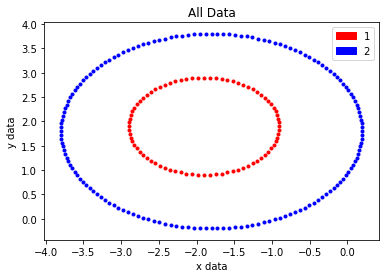

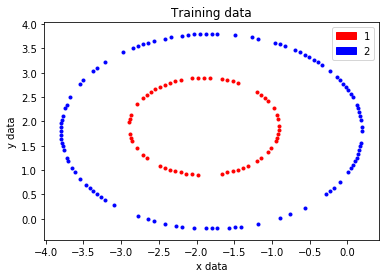

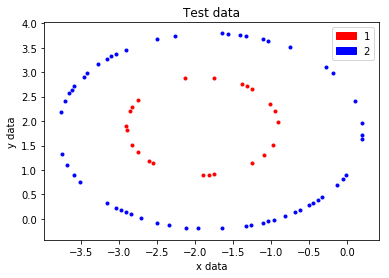

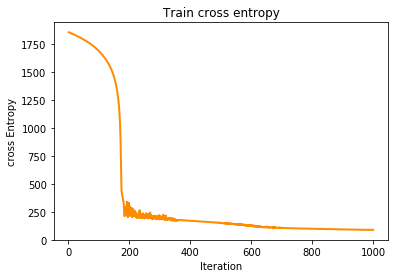

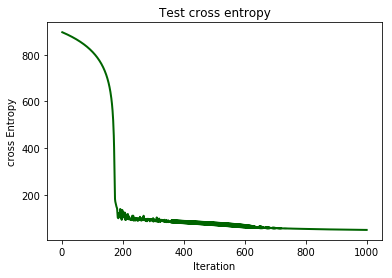

Iteration is 1000

Weight/Bias of layer1 after training
 [[ 4.88896839e-01  5.32009779e-01  6.31544445e-01  4.90581811e-01
   8.48241754e-01  9.02506914e-01  7.09503360e-01  3.76807769e-01
   7.26505037e-02  3.73502074e-01  1.37047667e+00  8.93502013e-01
   1.84966672e+00  5.82154179e-02  1.65204373e+00  1.59943673e+00
   7.94638076e-01  1.31295241e+00  8.56156964e-01  9.31214421e-01
   9.32268845e-02  8.50184446e-01  3.96544108e-01  5.44688928e-01
   1.02821283e-01  1.72861425e+00  4.08778634e-01  2.09743714e+00
   8.67473480e-01  8.21809714e-01  1.13938553e-01  1.06454936e+00
   8.47236952e-01 -2.89976509e-01  1.18211982e+00  3.52466688e-01
   9.02570849e-01  1.25784829e+00  2.75241635e-01  7.89425583e-01]
 [ 2.55520579e-01 -6.38276009e-01 -6.98436423e-01 -1.25489858e-01
  -1.46114370e+00 -7.85615510e-02 -3.13981873e-01 -8.01999508e-01
   8.64486790e-01 -7.94402499e-01  1.24594731e-01  6.14066371e-01
   6.91518580e-01  1.96981670e-01  5.42980156e-01  8.02513827e-01
  -3.91614516e-01 

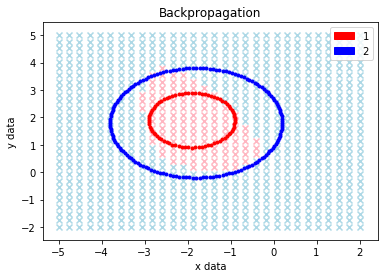

In [88]:
DataBackpropagation('2Ccircle1', 2, 1000, 2, 2, 0.04, 1, 40)